In [1]:
# import needed libraries.
import pandas as pd
import geopandas as gpd # geographic data manipulation
import numpy as np

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

import folium
from folium.plugins import HeatMap

from google.colab import drive #to mount google drive to the vm
import shutil

import os
!pip install python-dotenv
from dotenv import load_dotenv

# Load the .env file
load_dotenv('/content/.env')
# Mount Google Drive (need to be run only once!)
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download the dataset from google drive.
# Download the file from Google Drive using the file ID
!gdown {os.getenv('full-subway-manhattan-data')}

Downloading...
From (original): https://drive.google.com/uc?id=1BPFJv4QlUPr3Vywvk5dluiq9DQV19mhm
From (redirected): https://drive.google.com/uc?id=1BPFJv4QlUPr3Vywvk5dluiq9DQV19mhm&confirm=t&uuid=c8ca143e-f267-40db-8406-1f8f4a8a2679
To: /content/subway-data-may-29.csv
100% 9.95G/9.95G [01:02<00:00, 159MB/s]


In [3]:
#load the dataset into pandas df
df = pd.read_csv(f"/content/subway-data-may-29.csv")

<ipython-input-3-dde7986a472e>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/subway-data-may-29.csv")


In [4]:
# check the earliest and latest time of the data
print(df['transit_timestamp'].min())
print(df['transit_timestamp'].max())

01/01/2023 01:00:00 AM
12/31/2023 12:00:00 PM


In [5]:
#number of rows and cols
df.shape


(58306773, 12)

In [6]:
#check the data types
df.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
ridership                int64
transfers                int64
latitude               float64
longitude              float64
Georeference            object
dtype: object

In [7]:
#drop rows for which the borough is not Manhattan
# Filter rows where borough is not Manhattan (keep rows that have borough == manhattan)
df = df[df['borough'] == 'Manhattan']
df.drop(columns=['borough'], inplace=True)

# Reset index to have consecutive indices
df.reset_index(drop=True, inplace=True)

In [8]:
#drop the "payment_method" column as its content can be derived from the "fare_class_category" column.
df.drop(columns=['payment_method'], inplace=True)

# Reset index to have consecutive indices
df.reset_index(drop=True, inplace=True)

In [9]:
#drop the "Georeference" column as its content will be reconstructed using "latitude" and "longitude" columns .
df.drop(columns=['Georeference'], inplace=True)

# Reset index to have consecutive indices
df.reset_index(drop=True, inplace=True)

In [10]:
df_copy = df.copy()

In [11]:
#ensure that the precision of the long and lat is about 10 metre.
df['latitude'] = df['latitude'].round(4)
df['longitude'] = df['longitude'].round(4)

#reconstruct georeference from the long and lat cols.

df['georefence'] = df.apply(lambda row: f"POINT ({row['longitude']} {row['latitude']})", axis=1)

In [12]:
# Make sure the "station_complex_id" col only has numerical values.
# Replace 'TRAM1' with 888 and 'TRAM2' with 999 in the "station_complex_id" col
df['station_complex_id'] = df['station_complex_id'].replace({'TRAM1': 888, 'TRAM2': 999})
# Convert the 'id' column to integers
df['station_complex_id'] = df['station_complex_id'].astype(int)

In [13]:
# Convert transit_timestamp to datetime.
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Convert categorical columns to category data type
categorical_columns = ['transit_mode', 'station_complex_id', 'station_complex', 'fare_class_category','georefence']
df[categorical_columns] = df[categorical_columns].astype('category')

<ipython-input-13-1afd284d4338>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


In [14]:
#check the new types now
df.dtypes

transit_timestamp      datetime64[ns]
transit_mode                 category
station_complex_id           category
station_complex              category
fare_class_category          category
ridership                       int64
transfers                       int64
latitude                      float64
longitude                     float64
georefence                   category
dtype: object

In [15]:
#check number of rows and cols after all those modification above
#check number of columns after deletion
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns now")

There are 17806410 rows and 10 columns now


In [16]:
# check for Null, N/A and missing values by column
df.isnull().sum()

transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
fare_class_category    0
ridership              0
transfers              0
latitude               0
longitude              0
georefence             0
dtype: int64

In [17]:
#number of rows before dropping duplicate values
df.count()

transit_timestamp      17806410
transit_mode           17806410
station_complex_id     17806410
station_complex        17806410
fare_class_category    17806410
ridership              17806410
transfers              17806410
latitude               17806410
longitude              17806410
georefence             17806410
dtype: int64

In [18]:
#number of rows after dropping duplicate values
df = df.drop_duplicates()

df.count()

transit_timestamp      17806410
transit_mode           17806410
station_complex_id     17806410
station_complex        17806410
fare_class_category    17806410
ridership              17806410
transfers              17806410
latitude               17806410
longitude              17806410
georefence             17806410
dtype: int64

In [19]:
# Filter rows where transfers > ridership [this should never be the case as transfers are subset of ridership!]
condition = df['transfers'] > df['ridership']
filtered_df = df[condition]

# Get the count of such rows
count = filtered_df.shape[0]

print("Count of rows where transfers > ridership:", count)

Count of rows where transfers > ridership: 0


In [20]:
#show a sample of the data
df.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,fare_class_category,ridership,transfers,latitude,longitude,georefence
0,2024-04-25 17:00:00,subway,222,Roosevelt Island (F),Metrocard - Seniors & Disability,21,0,40.7591,-73.9533,POINT (-73.9533 40.7591)
1,2024-04-25 06:00:00,subway,310,"96 St (1,2,3)",Metrocard - Full Fare,49,2,40.7939,-73.9723,POINT (-73.9723 40.7939)
2,2024-04-25 10:00:00,subway,313,"72 St (1,2,3)",Metrocard - Unlimited 7-Day,90,0,40.7785,-73.9820,POINT (-73.982 40.7785)
3,2024-04-25 12:00:00,subway,329,Rector St (1),OMNY - Seniors & Disability,2,2,40.7075,-74.0138,POINT (-74.0138 40.7075)
4,2024-04-25 16:00:00,subway,146,181 St (A),OMNY - Seniors & Disability,7,0,40.8517,-73.9380,POINT (-73.938 40.8517)


In [21]:
# Get the number of unique values in the 'station_complex_id', 'station_complex', 'georeference' columns
count_unique_ids = df['station_complex_id'].nunique()
print(f'Number of unique station ids: {count_unique_ids}')

count_unique_stations = df['station_complex'].nunique()
print(f'Number of unique stations: {count_unique_stations}')

count_unique_geos = df['georefence'].nunique()
print(f'Number of unique georeferences: {count_unique_geos}')

Number of unique station ids: 123
Number of unique stations: 123
Number of unique georeferences: 168


In [22]:
df.dtypes

transit_timestamp      datetime64[ns]
transit_mode                 category
station_complex_id           category
station_complex              category
fare_class_category          category
ridership                       int64
transfers                       int64
latitude                      float64
longitude                     float64
georefence                   category
dtype: object

In [23]:
# Continuous Data Description
df[['ridership','transfers']].describe().T

,count,mean,std,min,25%,50%,75%,max
ridership,17806410.0,79.615992,234.50728,1.0,6.0,19.0,63.0,14243.0
transfers,17806410.0,1.768533,10.12933,0.0,0.0,0.0,1.0,1129.0


In [24]:
# Categorical Data Description
df.describe(include=['category']).T

,count,unique,top,freq
transit_mode,17806410,2,subway,17585299
station_complex_id,17806410,123,611,170371
station_complex,17806410,123,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",170371
fare_class_category,17806410,10,Metrocard - Full Fare,2371477
georefence,17806410,168,POINT (-73.9768 40.7518),166323


In [25]:
#the number of unique values in each column.
df.nunique()

transit_timestamp      20227
transit_mode               2
station_complex_id       123
station_complex          123
fare_class_category       10
ridership               7135
transfers                834
latitude                 144
longitude                142
georefence               168
dtype: int64

In [28]:
def generate_boxplot_histogram(feature_name):
    #histogram and boxplot for "feature_name" column.
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Histogram
    axs[0].hist(df[feature_name], bins=30, color='blue', edgecolor='black')
    axs[0].set_title(f'Histogram of {feature_name}')
    axs[0].set_xlabel(feature_name)
    axs[0].set_ylabel('Frequency')

    # Boxplot
    axs[1].boxplot(df[feature_name])
    axs[1].set_title(f'Boxplot of {feature_name}')
    axs[1].set_ylabel(feature_name)

    plt.tight_layout()
    plt.show()

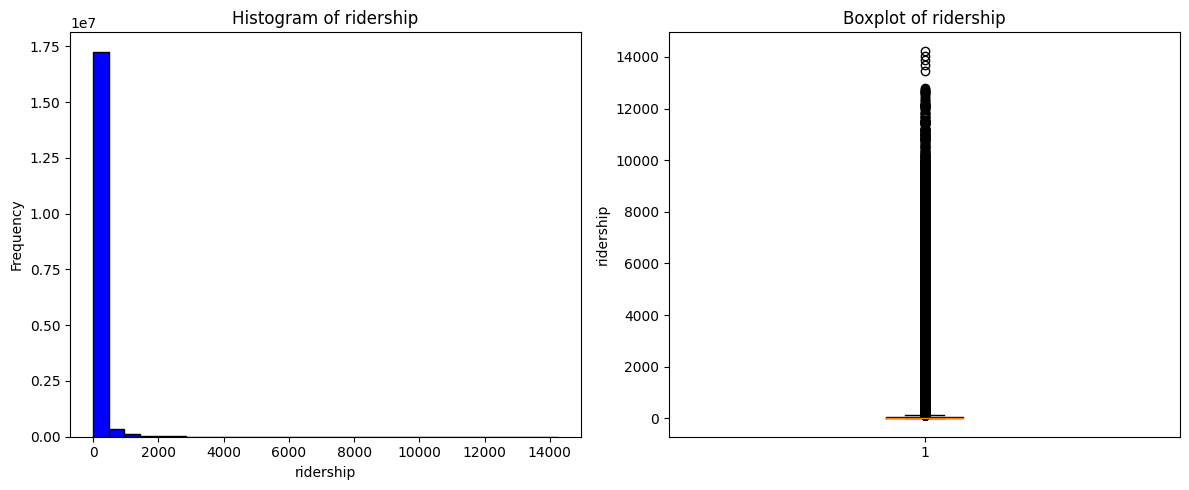

In [29]:
#histogram and boxplot for ridership column.
generate_boxplot_histogram("ridership")

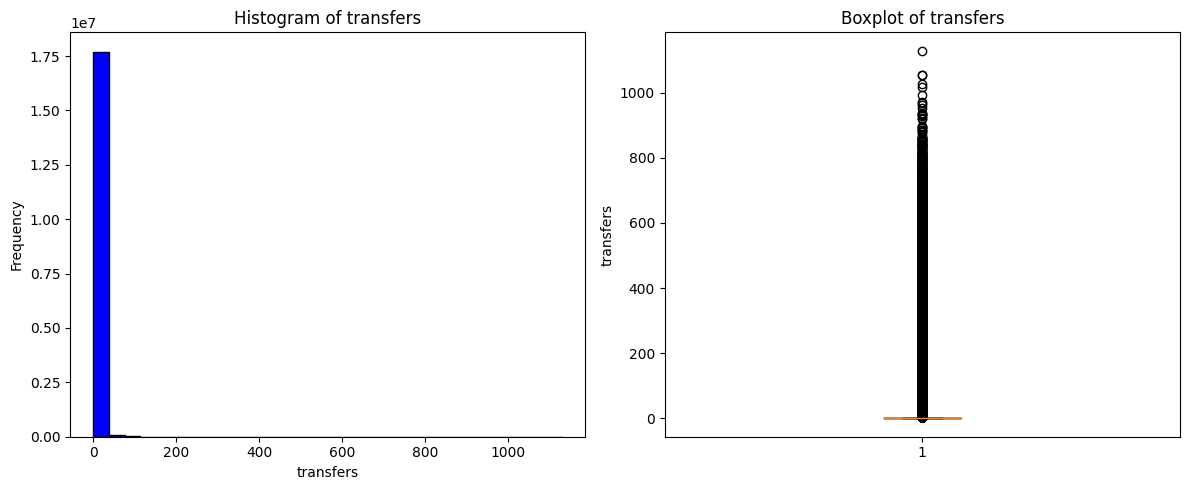

In [30]:
#histogram and boxplot for transfers column.
generate_boxplot_histogram("transfers")

In [31]:
# Creating new columns
df['date'] = df['transit_timestamp'].dt.date
df['month'] = df['transit_timestamp'].dt.month
df['week_of_year'] = df['transit_timestamp'].dt.isocalendar().week
df['day'] = df['transit_timestamp'].dt.day_name()
df['hour'] = df['transit_timestamp'].dt.hour

# Function to determine rush hour (no rush hours in weekends)
def is_rush_hour(row):
    if row['day'] in ['Saturday', 'Sunday']:
        return False
    if (row['hour'] >= 7 and row['hour'] < 9) or (row['hour'] >= 15 and row['hour'] < 19):
        return True
    return False

df['is_rush_hour'] = df.apply(is_rush_hour, axis=1)

# Creating the is_weekend column
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

In [32]:
# Count the number of records for each hour
hourly_counts = df['hour'].value_counts().sort_index()

# Display the hourly counts
hourly_counts


hour
0     626091
1     522599
2     452437
3     434423
4     513210
5     651162
6     757269
7     806761
8     824028
9     826805
10    829664
11    836477
12    844165
13    846066
14    848285
15    849780
16    851449
17    851444
18    844579
19    829077
20    813029
21    743621
22    719059
23    684930
Name: count, dtype: int64

In [35]:
#Analyze the outliers.
Q1 = df['ridership'].quantile(0.25)
Q3 = df['ridership'].quantile(0.75)
IQR = Q3 - Q1

#check for outliers
numeric_cols = df['ridership']
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
print(f"The inter-quartile range is {IQR}")


The inter-quartile range is 57.0


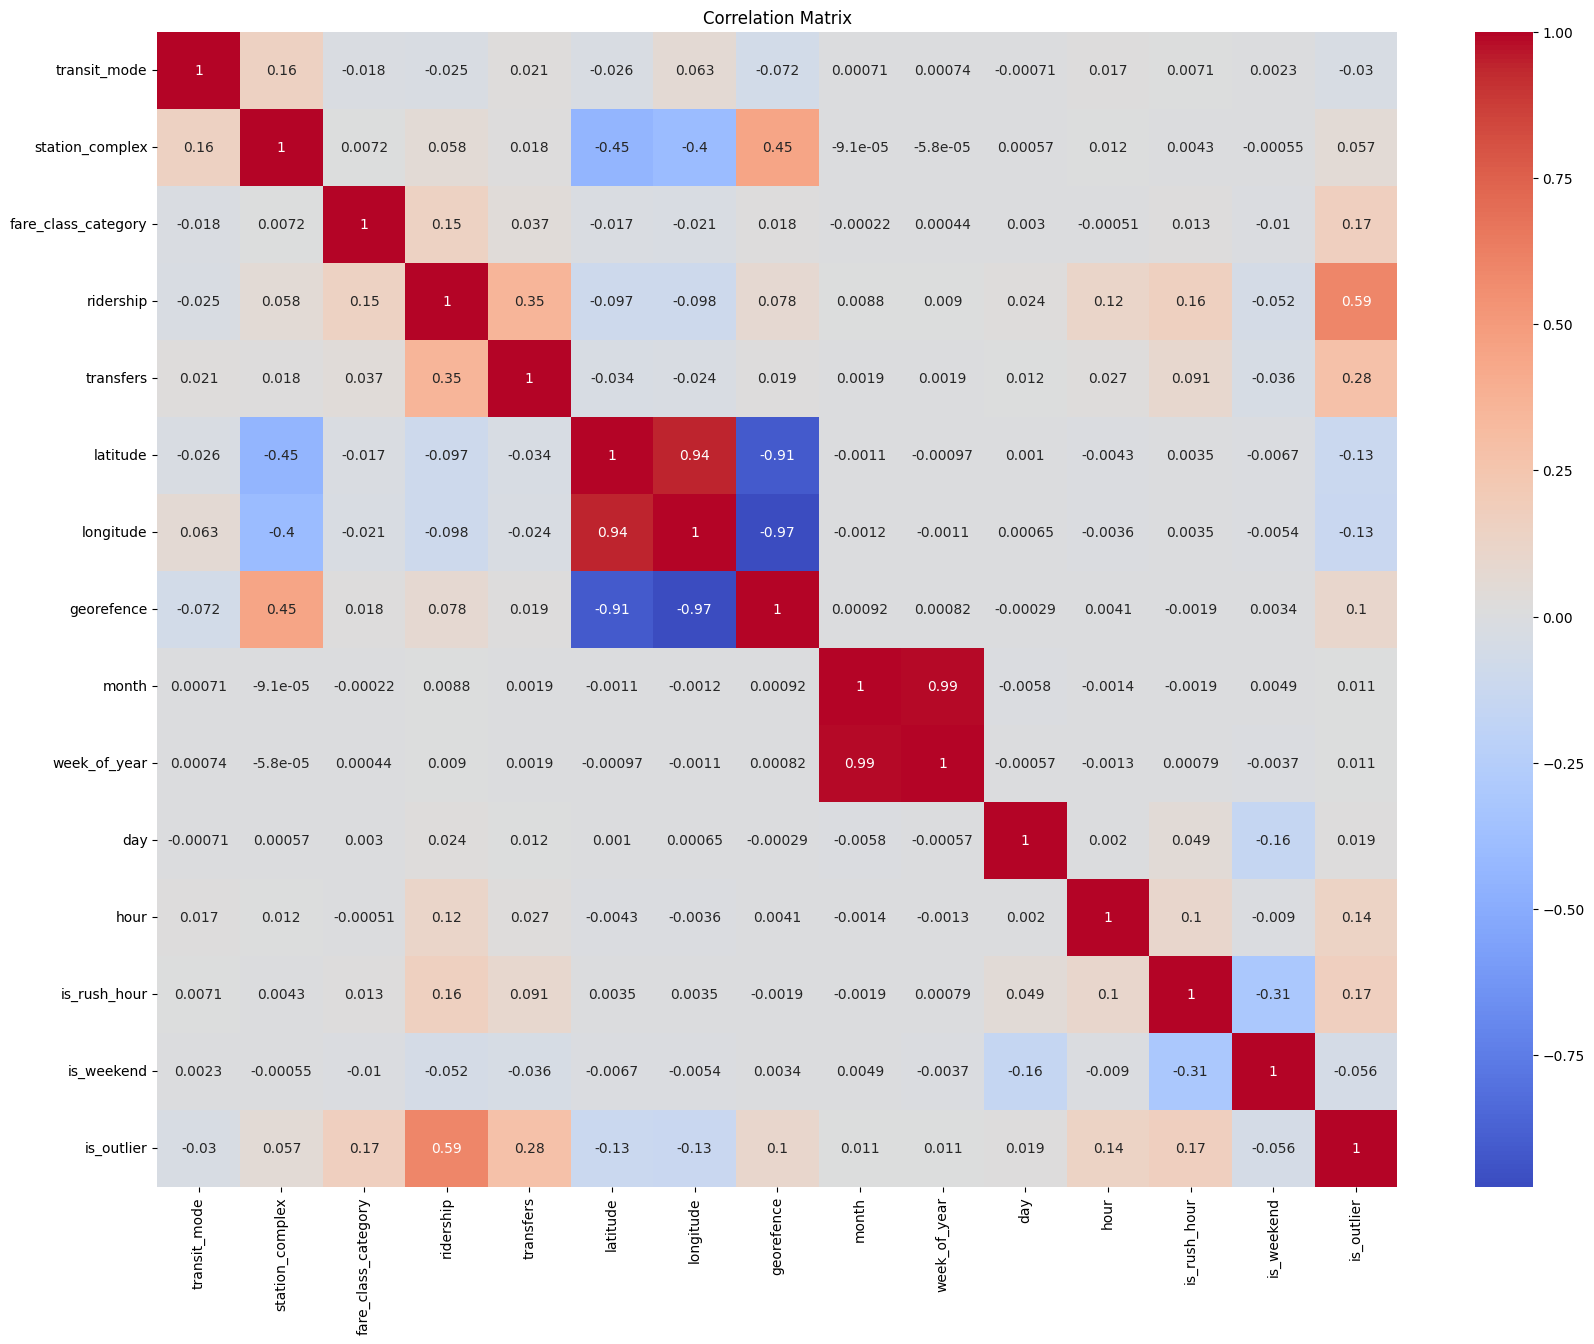

,transit_timestamp,transit_mode,station_complex_id,station_complex,fare_class_category,ridership,transfers,latitude,longitude,georefence,date,month,week_of_year,day,hour,is_rush_hour,is_weekend
0,2024-04-25 17:00:00,subway,222,Roosevelt Island (F),Metrocard - Seniors & Disability,21,0,40.7591,-73.9533,POINT (-73.9533 40.7591),2024-04-25,4,17,Thursday,17,True,False
1,2024-04-25 06:00:00,subway,310,"96 St (1,2,3)",Metrocard - Full Fare,49,2,40.7939,-73.9723,POINT (-73.9723 40.7939),2024-04-25,4,17,Thursday,6,False,False
2,2024-04-25 10:00:00,subway,313,"72 St (1,2,3)",Metrocard - Unlimited 7-Day,90,0,40.7785,-73.9820,POINT (-73.982 40.7785),2024-04-25,4,17,Thursday,10,False,False
3,2024-04-25 12:00:00,subway,329,Rector St (1),OMNY - Seniors & Disability,2,2,40.7075,-74.0138,POINT (-74.0138 40.7075),2024-04-25,4,17,Thursday,12,False,False
4,2024-04-25 16:00:00,subway,146,181 St (A),OMNY - Seniors & Disability,7,0,40.8517,-73.9380,POINT (-73.938 40.8517),2024-04-25,4,17,Thursday,16,True,False


In [36]:
#Correlation_matrix
ndf = df.copy()

# Step 2: Determine which rows are outliers
outlier_condition = (ndf['ridership'] < (Q1 - 1.5 * IQR)) | (ndf['ridership'] > (Q3 + 1.5 * IQR))

# Step 3: Add a new column to indicate whether each row is an outlier
ndf['is_outlier'] = outlier_condition

# Convert categorical columns to numerical values for correlation analysis
ndf['transit_mode'] = ndf['transit_mode'].astype('category').cat.codes
ndf['station_complex'] = ndf['station_complex'].astype('category').cat.codes
ndf['fare_class_category'] = ndf['fare_class_category'].astype('category').cat.codes
ndf['georefence'] = ndf['georefence'].astype('category').cat.codes
ndf['day'] = ndf['day'].astype('category').cat.codes

# Step 4: Plot the correlation matrix
correlation_matrix = ndf.corr(numeric_only=True)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [71]:
from scipy.stats import chi2_contingency
def create_contingency_table(dataframe, feature_name, verbose=False, figure_size = 14):
    # Create a contingency table for is_outlier and "feature_name"
    #contingency_table: The resulting table will show the frequency (count) of occurrences for each combination of values in ndf['is_outlier'] and ndf['feature_name'].
    contingency_table = pd.crosstab(dataframe['is_outlier'],dataframe[feature_name])

    # Perform chi-square test
    # The test evaluates whether there is a significant association between two categorical variables. It compares the observed frequencies in the contingency table with the expected frequencies if there were no association between the variables.
    #The p-value of the test, which indicates the probability of observing the data if there is no association between the two categorical variables.
    #If the p-value is low (<= 0.05), you conclude that there is a significant association between the two variables or features.
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print("Chi-square test statistic:", chi2)
    print("p-value:", p)
    if verbose:
        print()
        print(contingency_table)
        print()
    # Interpret the p-value
    alpha = 0.05
    if p < alpha:
        print("There is a statistically significant association between outliers and the hour of the day.")
    else:
        print("There is no statistically significant association between outliers and the hour of the day.")

    # Bar plot to visualize the distribution of outliers during rush hours and non-rush hours
    contingency_table.T.plot(kind='bar', stacked=True, figsize=(figure_size, 8), color=['blue', 'orange'])
    plt.title(f'Distribution of Outliers for each category of {feature_name}')
    plt.xlabel(f'{feature_name}')
    plt.ylabel('Count')
    plt.legend(title="is outlier?")
    plt.xticks(rotation=90)
    plt.show()




Chi-square test statistic: 528301.5502057109
p-value: 0.0

is_rush_hour     False    True 
is_outlier                     
False         12790837  2907601
True           1258989   848983

There is a statistically significant association between outliers and the hour of the day.


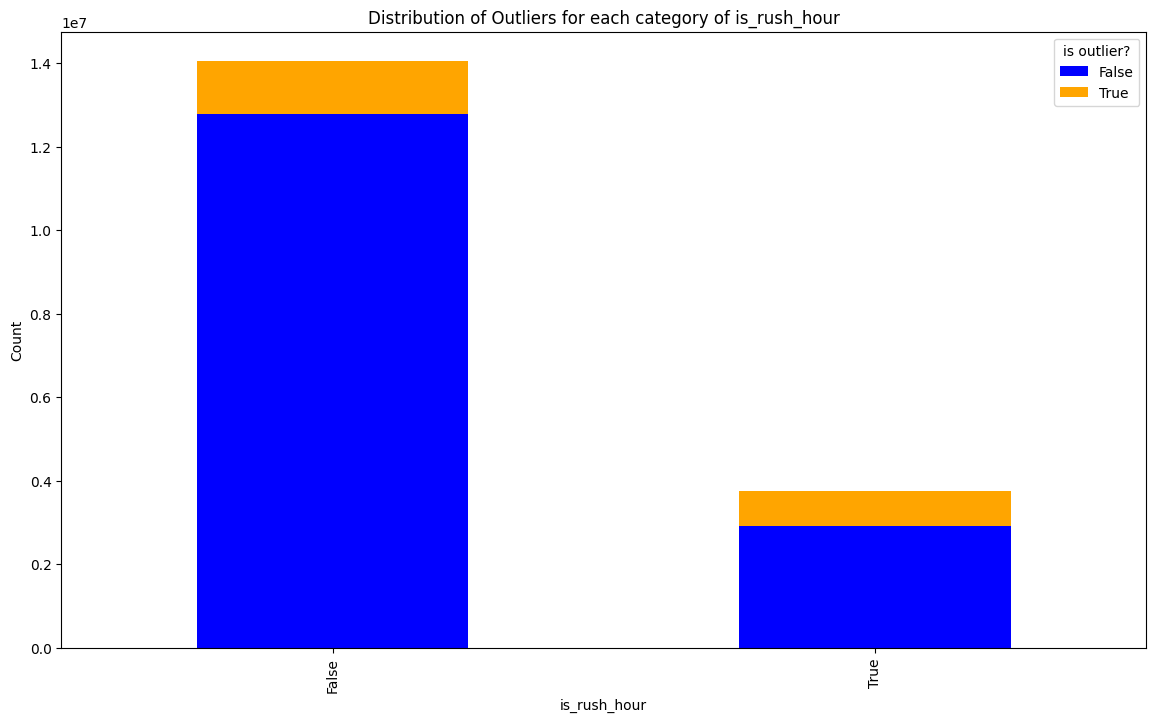

In [72]:
create_contingency_table(ndf, "is_rush_hour", verbose=True)

Chi-square test statistic: 986998.7877244136
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


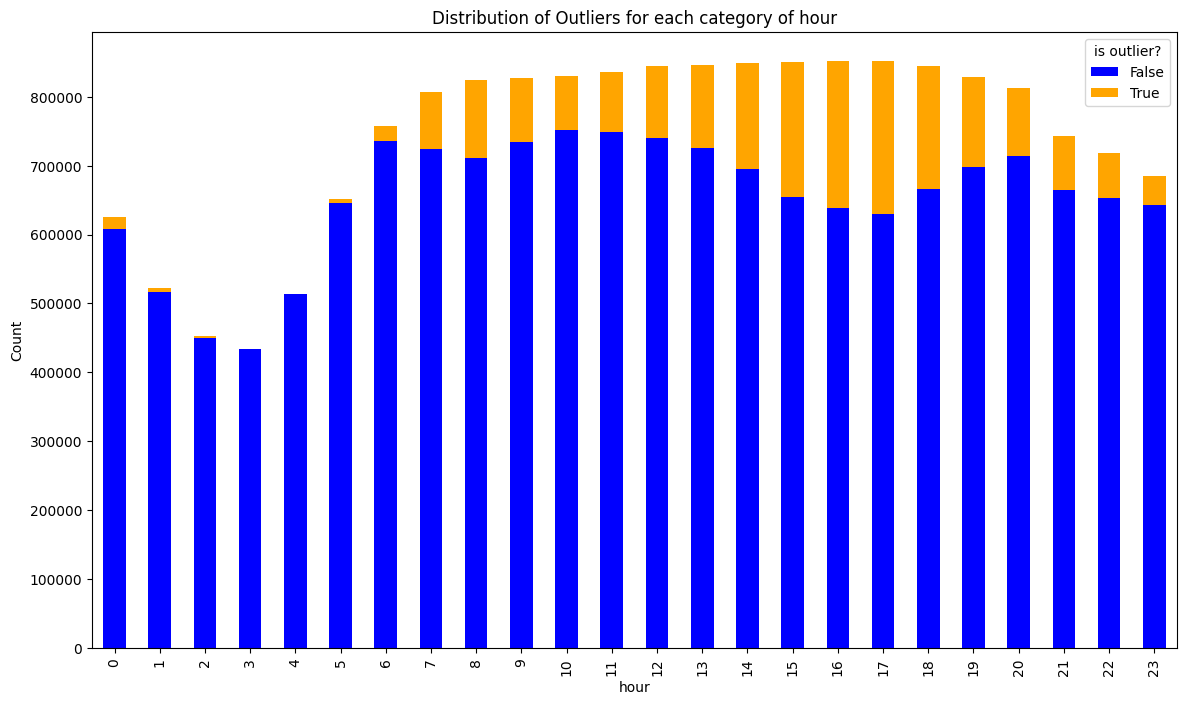

In [73]:
create_contingency_table(ndf, "hour")

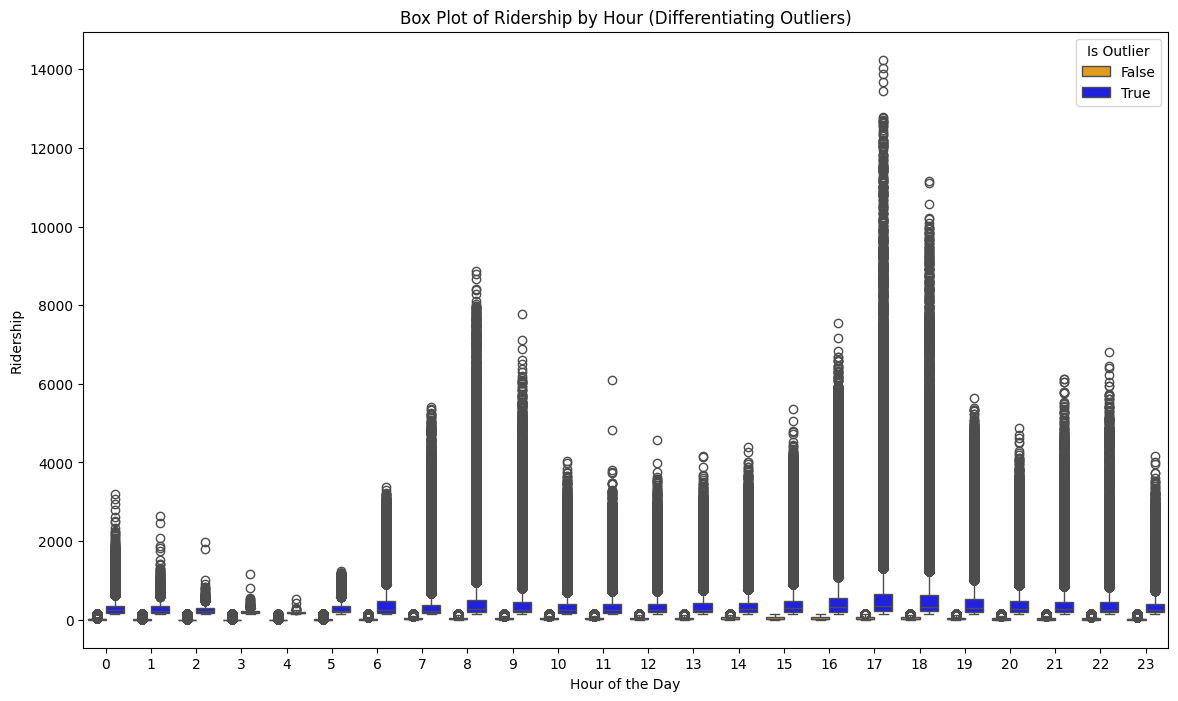

In [116]:
# Create the box plot for each hour
plt.figure(figsize=(14, 8))
sns.boxplot(x='hour', y='ridership', hue='is_outlier', data=ndf, palette=['orange', 'blue'])
plt.title('Box Plot of Ridership by Hour (Differentiating Outliers)')
plt.xlabel('Hour of the Day')
plt.ylabel('Ridership')
plt.legend(title='Is Outlier')
plt.show()



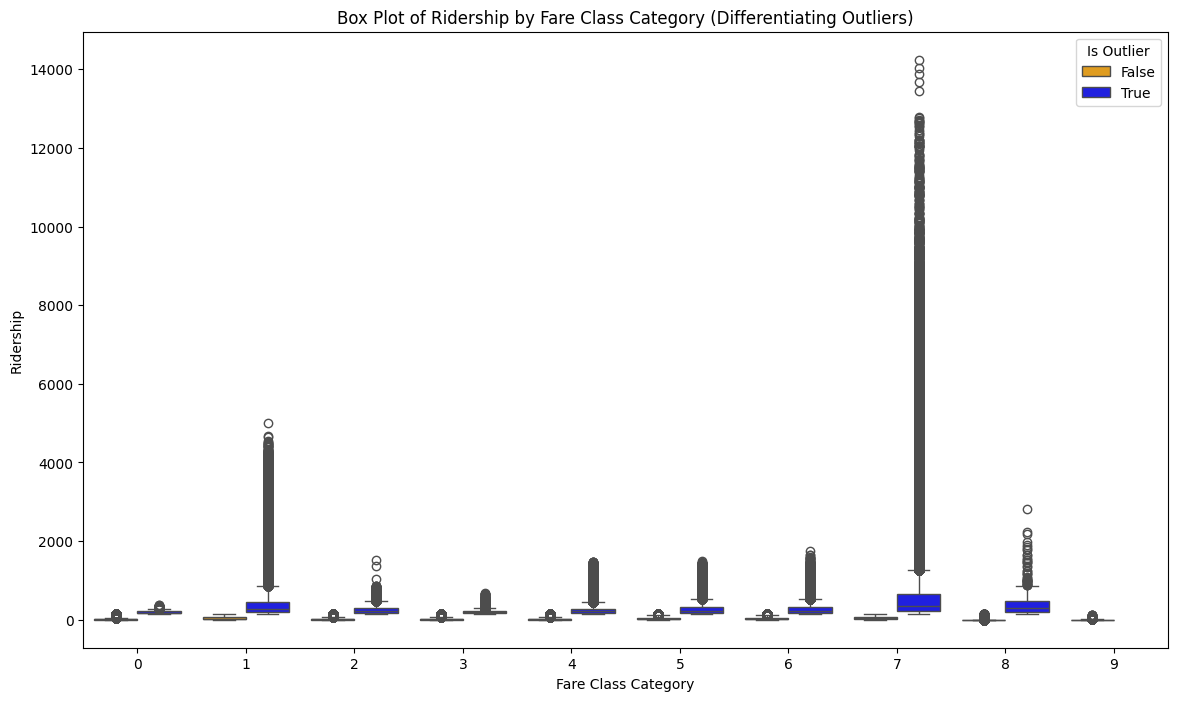

In [117]:
# Creating a box plot to visualize the relationship between fare_class_category and ridership while differentiating outliers
plt.figure(figsize=(14, 8))
sns.boxplot(x='fare_class_category', y='ridership', hue='is_outlier', data=ndf, palette=['orange', 'blue'])
plt.title('Box Plot of Ridership by Fare Class Category (Differentiating Outliers)')
plt.xlabel('Fare Class Category')
plt.ylabel('Ridership')
plt.legend(title='Is Outlier')
plt.show()


In [ ]:
# Create a mapping dictionary
fare_class_mapping = dict(enumerate(df['fare_class_category'].cat.categories))

# Display the mapping
fare_class_mapping

{0: 'Metrocard - Fair Fare',
 1: 'Metrocard - Full Fare',
 2: 'Metrocard - Other',
 3: 'Metrocard - Seniors & Disability',
 4: 'Metrocard - Students',
 5: 'Metrocard - Unlimited 30-Day',
 6: 'Metrocard - Unlimited 7-Day',
 7: 'OMNY - Full Fare',
 8: 'OMNY - Other',
 9: 'OMNY - Seniors & Disability'}

Chi-square test statistic: 3377029.2214549338
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


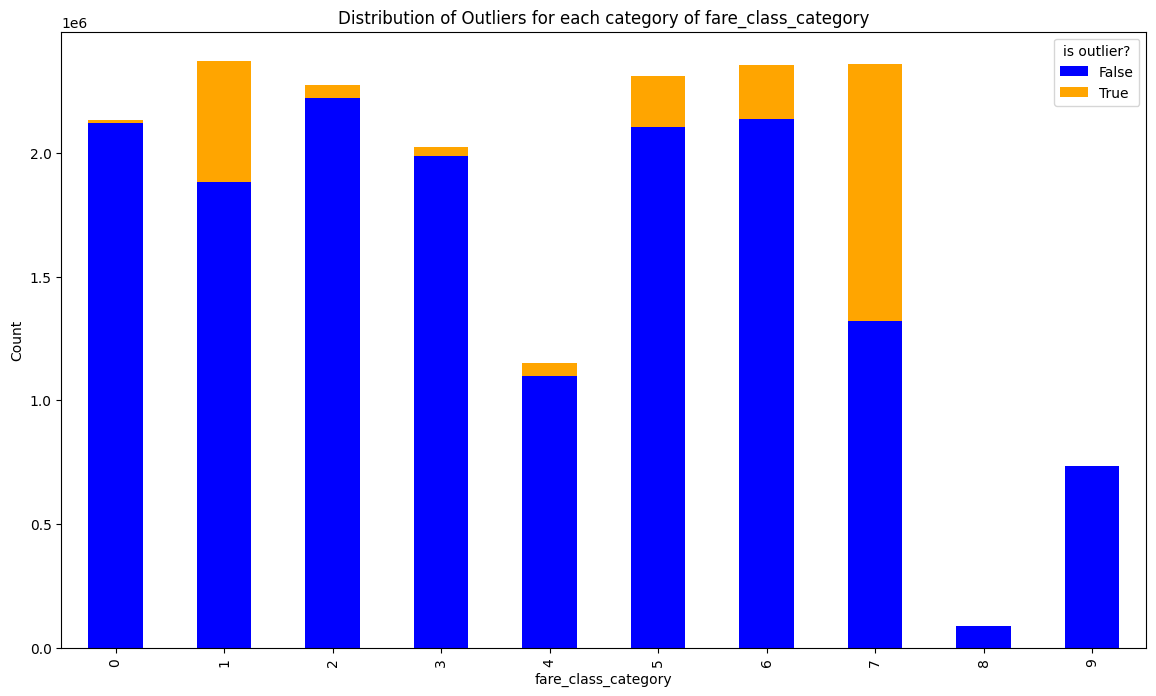

In [74]:
create_contingency_table(ndf, "fare_class_category")

In [ ]:
# Summary statistics for ridership by fare_class_category differentiating outliers
summary_stats_fare = ndf.groupby(['fare_class_category', 'is_outlier'])['ridership'].describe()

print("Summary Statistics:\n", summary_stats_fare)

Summary Statistics:
                                    count        mean         std    min  \
fare_class_category is_outlier                                            
0                   False       919427.0   16.221240   20.090519    1.0   
                    True          5829.0  193.083719   40.162310  148.0   
1                   False       822242.0   43.722645   39.237739    1.0   
                    True        202123.0  413.971057  395.952136  148.0   
2                   False       961281.0   20.613939   25.152885    1.0   
                    True         25354.0  249.325945  104.420811  148.0   
3                   False       860444.0   20.560705   25.387290    1.0   
                    True         18114.0  202.086452   48.929207  148.0   
4                   False       473954.0   23.248790   29.721654    1.0   
                    True         23018.0  257.623338  142.554263  148.0   
5                   False       910212.0   34.717315   34.255837    1.0   
    

In [ ]:
#group the df by station_complex to plot the total ridership for each station complex.
#group by month to plot the total ridership per month
#group by week of the year (1, 53) weeks to plot the total ridership for each week.

Chi-square test statistic: 1865578.1545207046
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


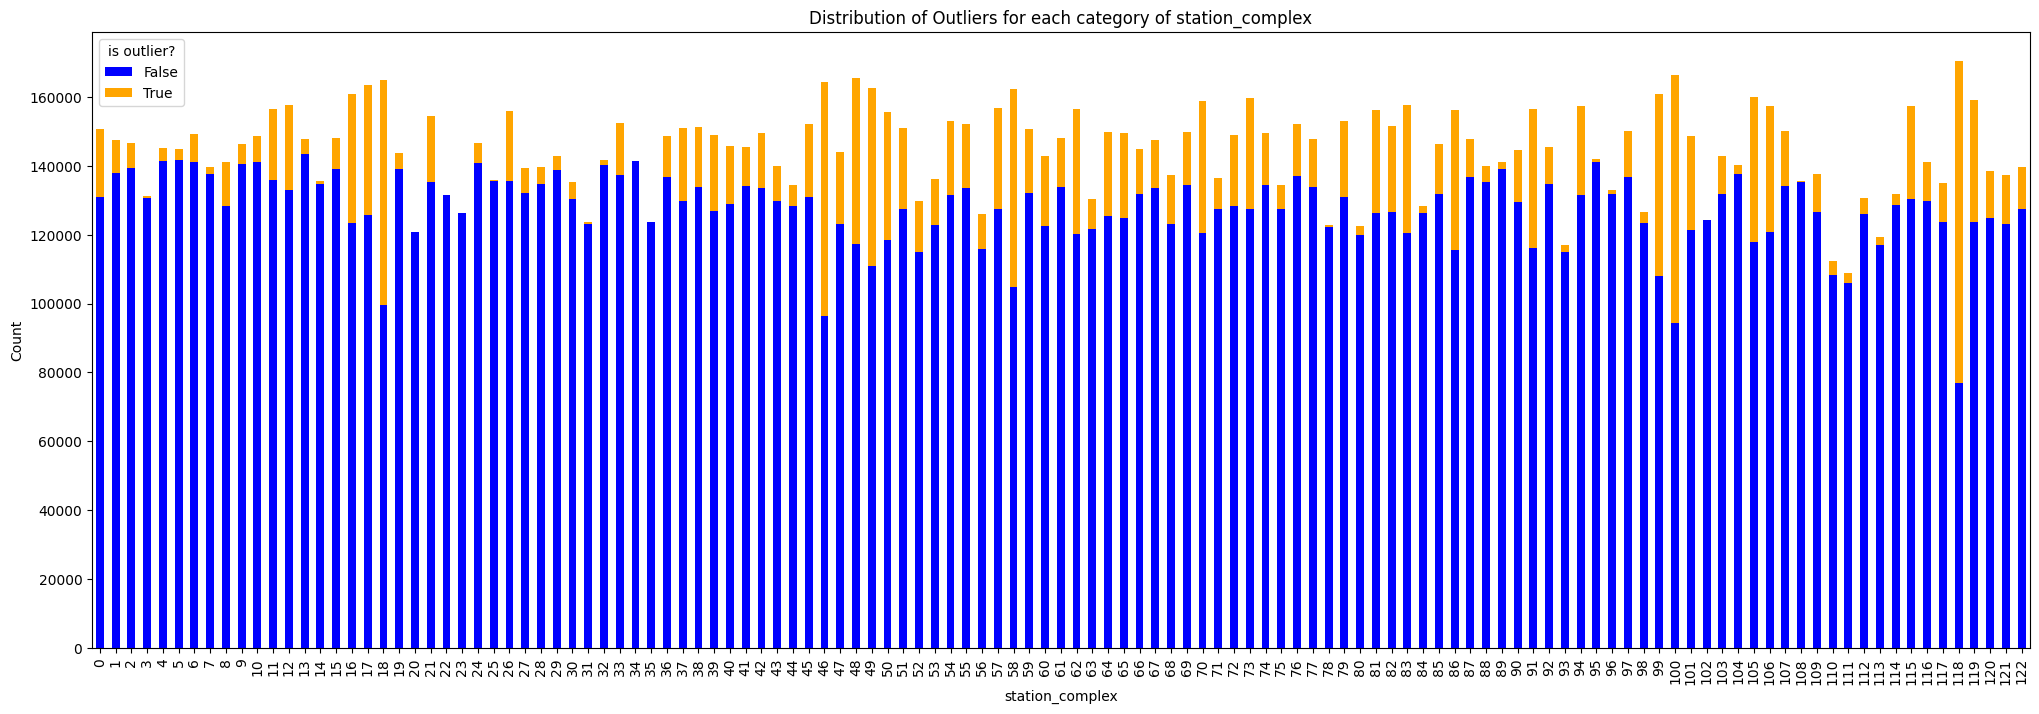

In [75]:
# Box Plot of Ridership by Station Complex (Differentiating Outliers)
create_contingency_table(ndf, "station_complex", verbose=False, figure_size=25)


Chi-square test statistic: 2094870.452311066
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


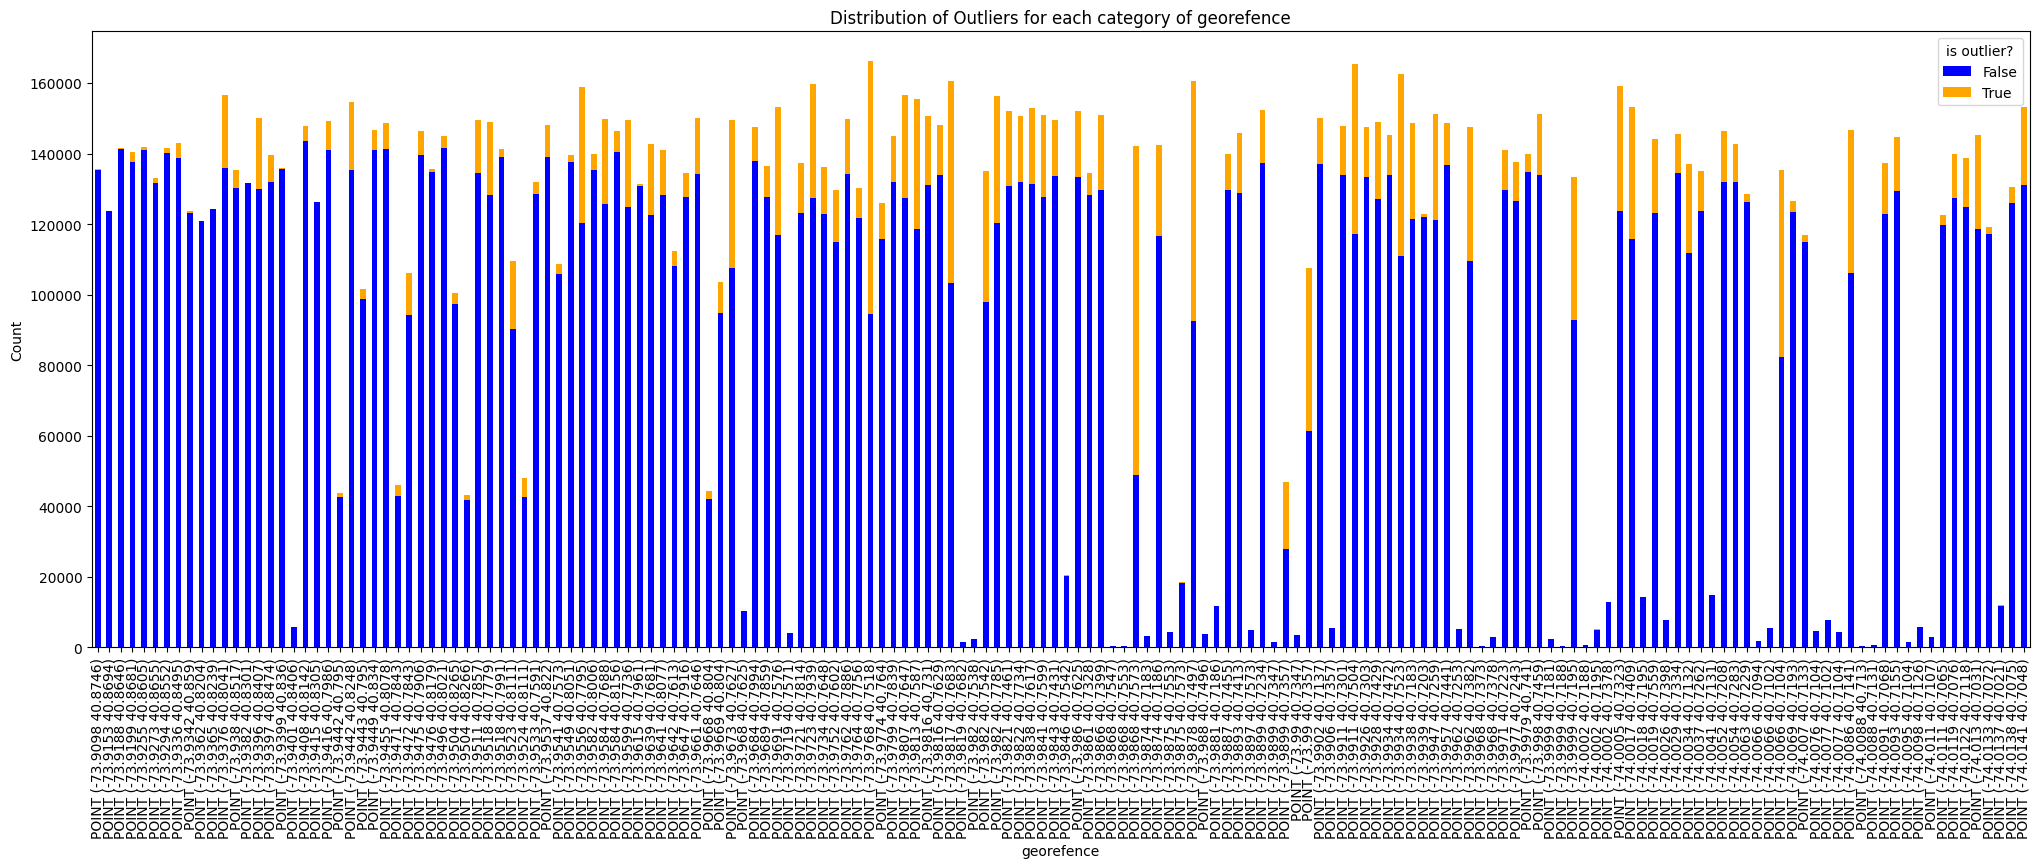

In [78]:
# Box Plot of Ridership by georeference (Differentiating Outliers)
ddf = df.copy()
ddf['is_outlier'] = outlier_condition
create_contingency_table(ddf, "georefence", verbose=False, figure_size=25)

In [80]:
#HeatMap showing the outliers..
# Filter the outliers
outliers_df = ddf[ddf['is_outlier']]

# Group data by georefence and calculate the count of outliers at each location
location_outliers = outliers_df.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# Create a map centered around New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add a heat map to the map
HeatMap(location_outliers[['latitude', 'longitude', 'count']].values).add_to(m)

m

Chi-square test statistic: 5425.397601134161
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


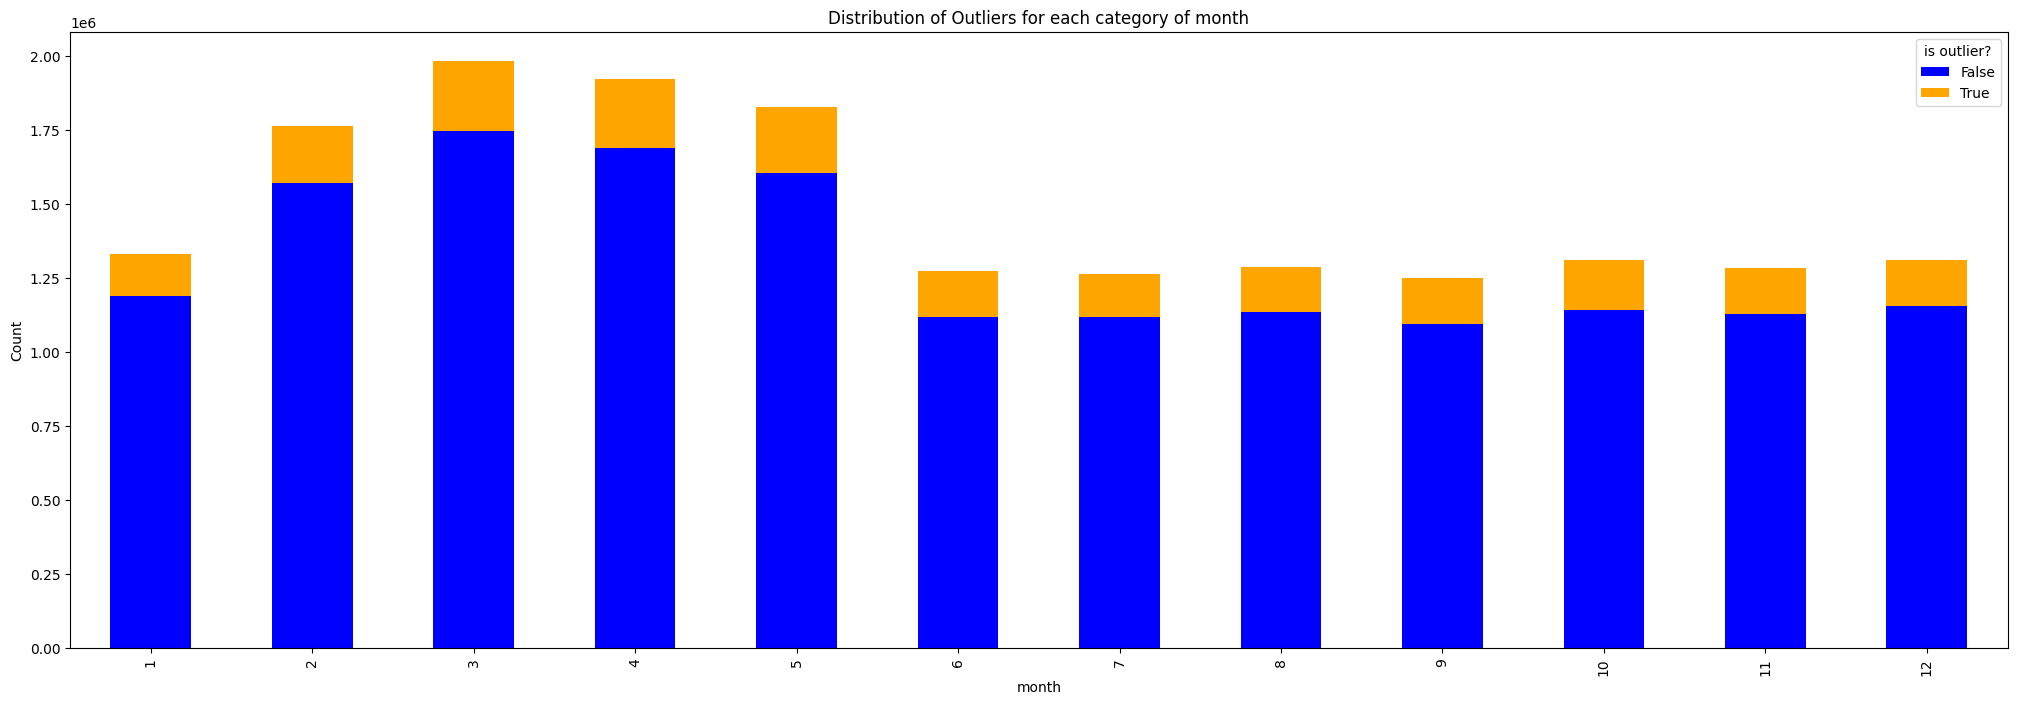

In [82]:
create_contingency_table(ndf, "month", verbose=False, figure_size=25)


Chi-square test statistic: 10990.08080861361
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


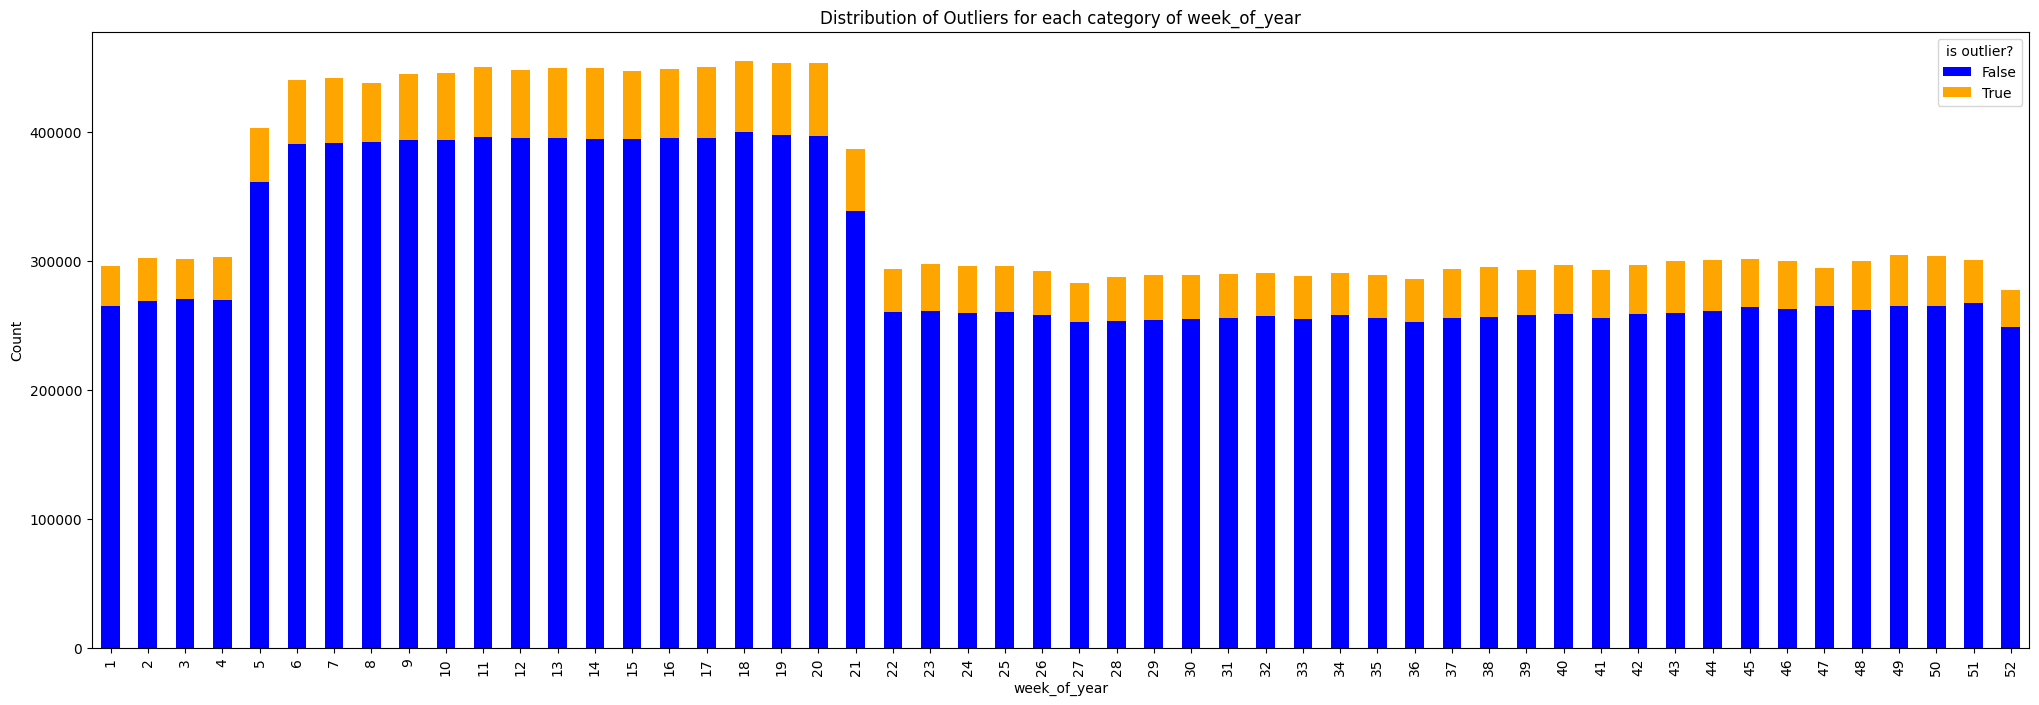

In [84]:
create_contingency_table(ndf, "week_of_year", verbose=False, figure_size=25)


Chi-square test statistic: 65117.48208615185
p-value: 0.0
There is a statistically significant association between outliers and the hour of the day.


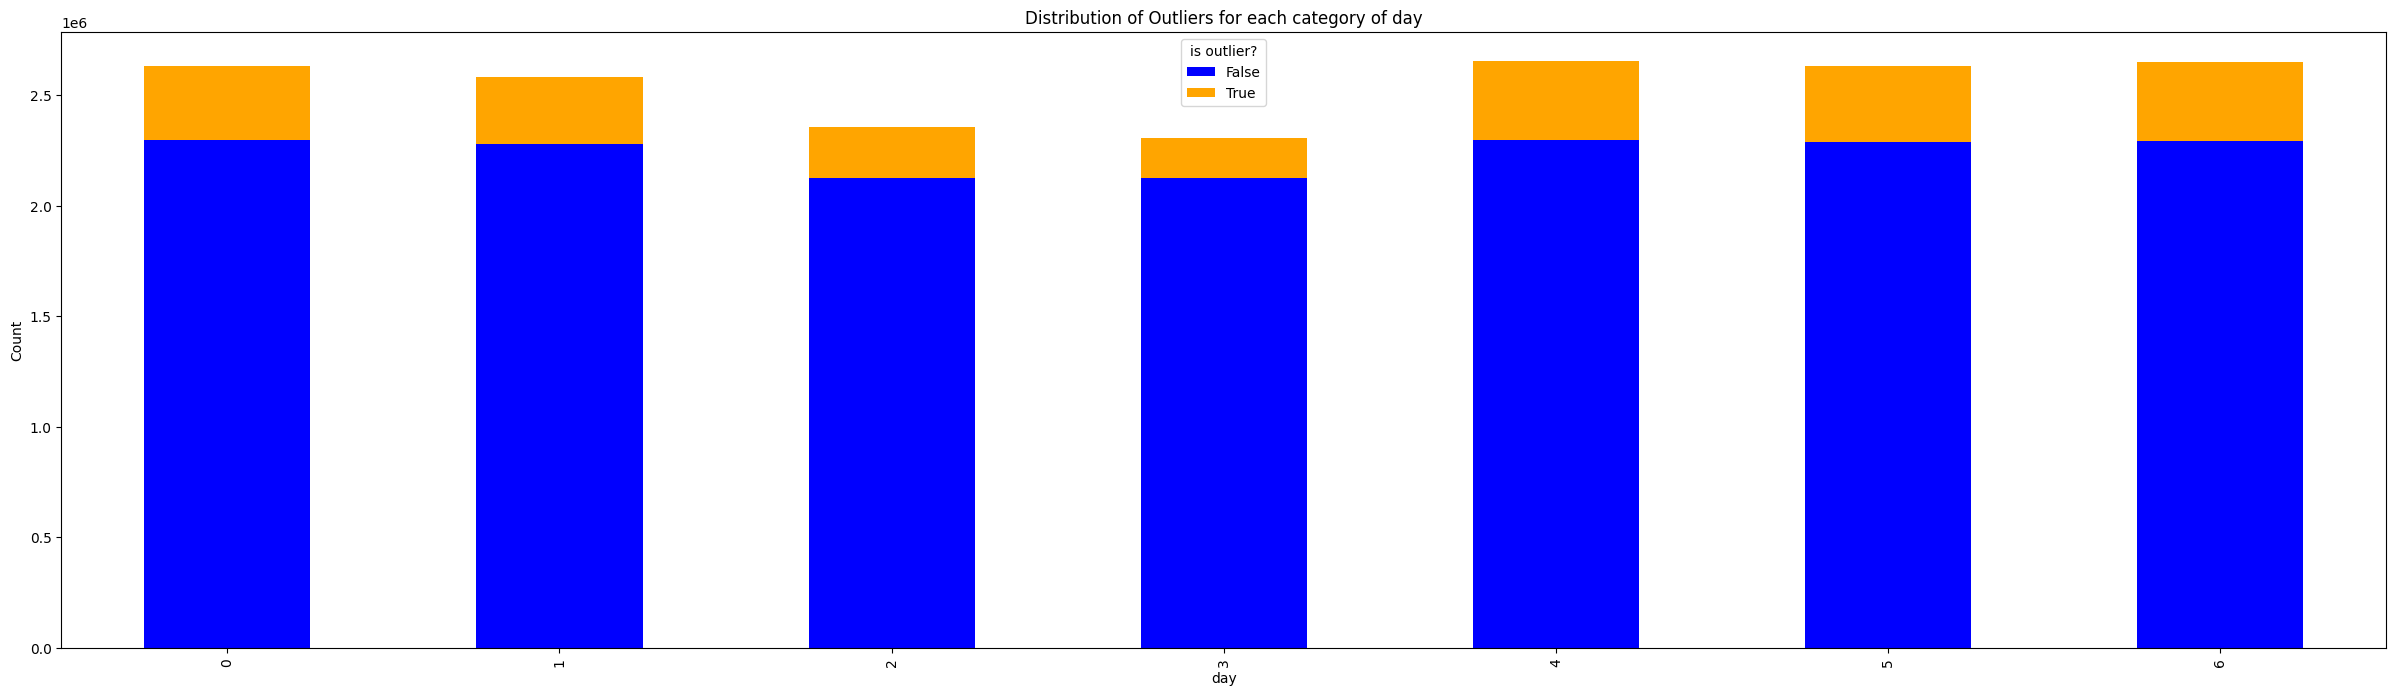

In [85]:
create_contingency_table(ndf, "day", verbose=False, figure_size=30)


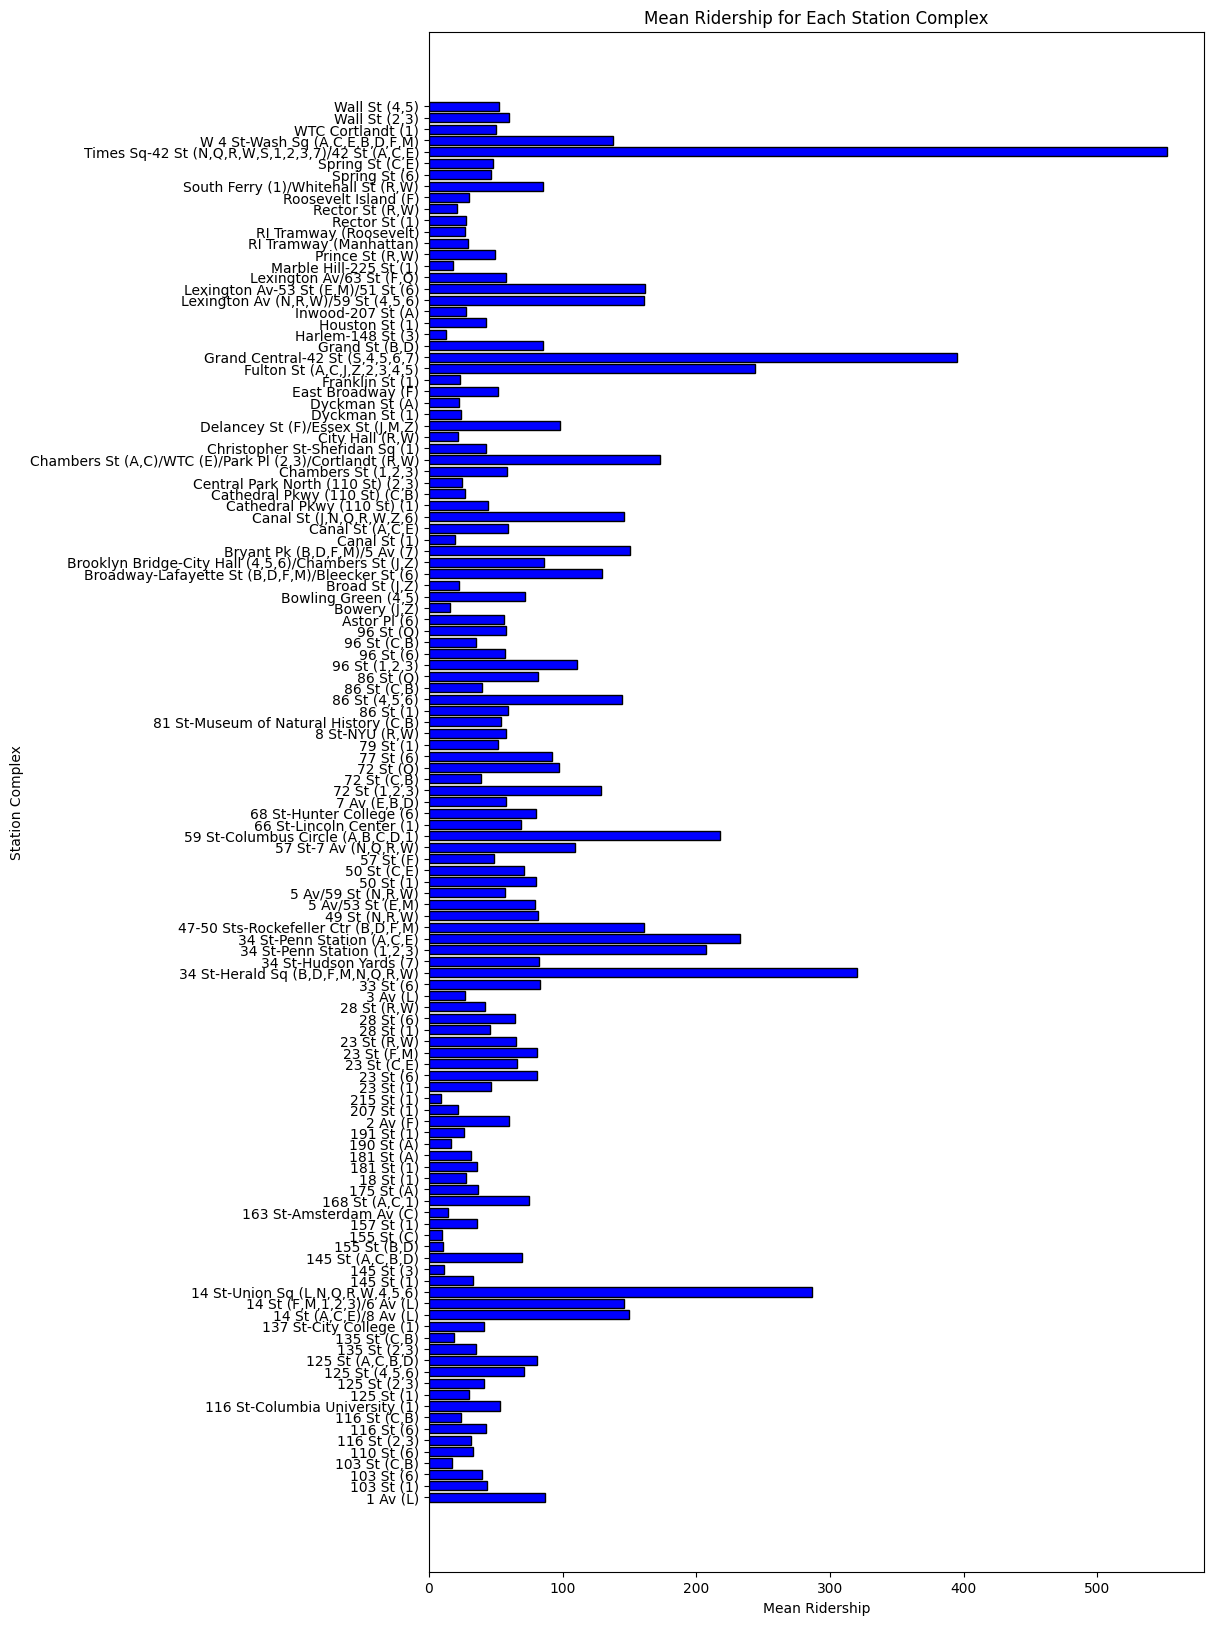

In [86]:
# Grouping the DataFrame by 'station_complex' to get the total ridership for each station complex
grouped_df = df.groupby('station_complex')['ridership'].mean().reset_index()

# Plotting the total ridership for each station complex with stations on the vertical axis
plt.figure(figsize=(10, 20))
plt.barh(grouped_df['station_complex'], grouped_df['ridership'], color='blue', edgecolor='black')
plt.title('Mean Ridership for Each Station Complex')
plt.xlabel('Mean Ridership')
plt.ylabel('Station Complex')
plt.show()

In [104]:
def plot_stats_per_period(period):
    # Grouping the DataFrame by 'period' to get various statistics for each period
    stats = ndf.groupby(f'{period}')['ridership'].agg(['sum', 'mean', 'median', 'std']).reset_index()

    # Plotting the total ridership for each period (sum, mean, median, std) in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=True)

    # Sum
    axs[0, 0].plot(stats[period], stats['sum'], marker='o', linestyle='-', color='blue')
    axs[0, 0].set_title(f'Total Ridership per {period} (Sum)')
    axs[0, 0].set_ylabel('Sum')

    # Mean
    axs[0, 1].plot(stats[period], stats['mean'], marker='o', linestyle='-', color='green')
    axs[0, 1].set_title(f'Average Ridership per {period} (Mean)')
    axs[0, 1].set_ylabel('Mean')

    # Median
    axs[1, 0].plot(stats[period], stats['median'], marker='o', linestyle='-', color='red')
    axs[1, 0].set_title(f'Median Ridership per {period}')
    axs[1, 0].set_ylabel('Median')

    # Standard Deviation
    axs[1, 1].plot(stats[period], stats['std'], marker='o', linestyle='-', color='purple')
    axs[1, 1].set_title(f'Standard Deviation of Ridership per {period}')
    axs[1, 1].set_ylabel('Standard Deviation')

    # Formatting the x-axis
    for ax in axs.flat:
        ax.set_xticks(range(1,ndf[period].nunique()+1))
        # ax.set_xticklabels(month_labels)
        ax.set_xlabel(f'{period}')
        ax.xaxis.set_tick_params(rotation=45)
        ax.grid()

    plt.tight_layout()
    plt.show()


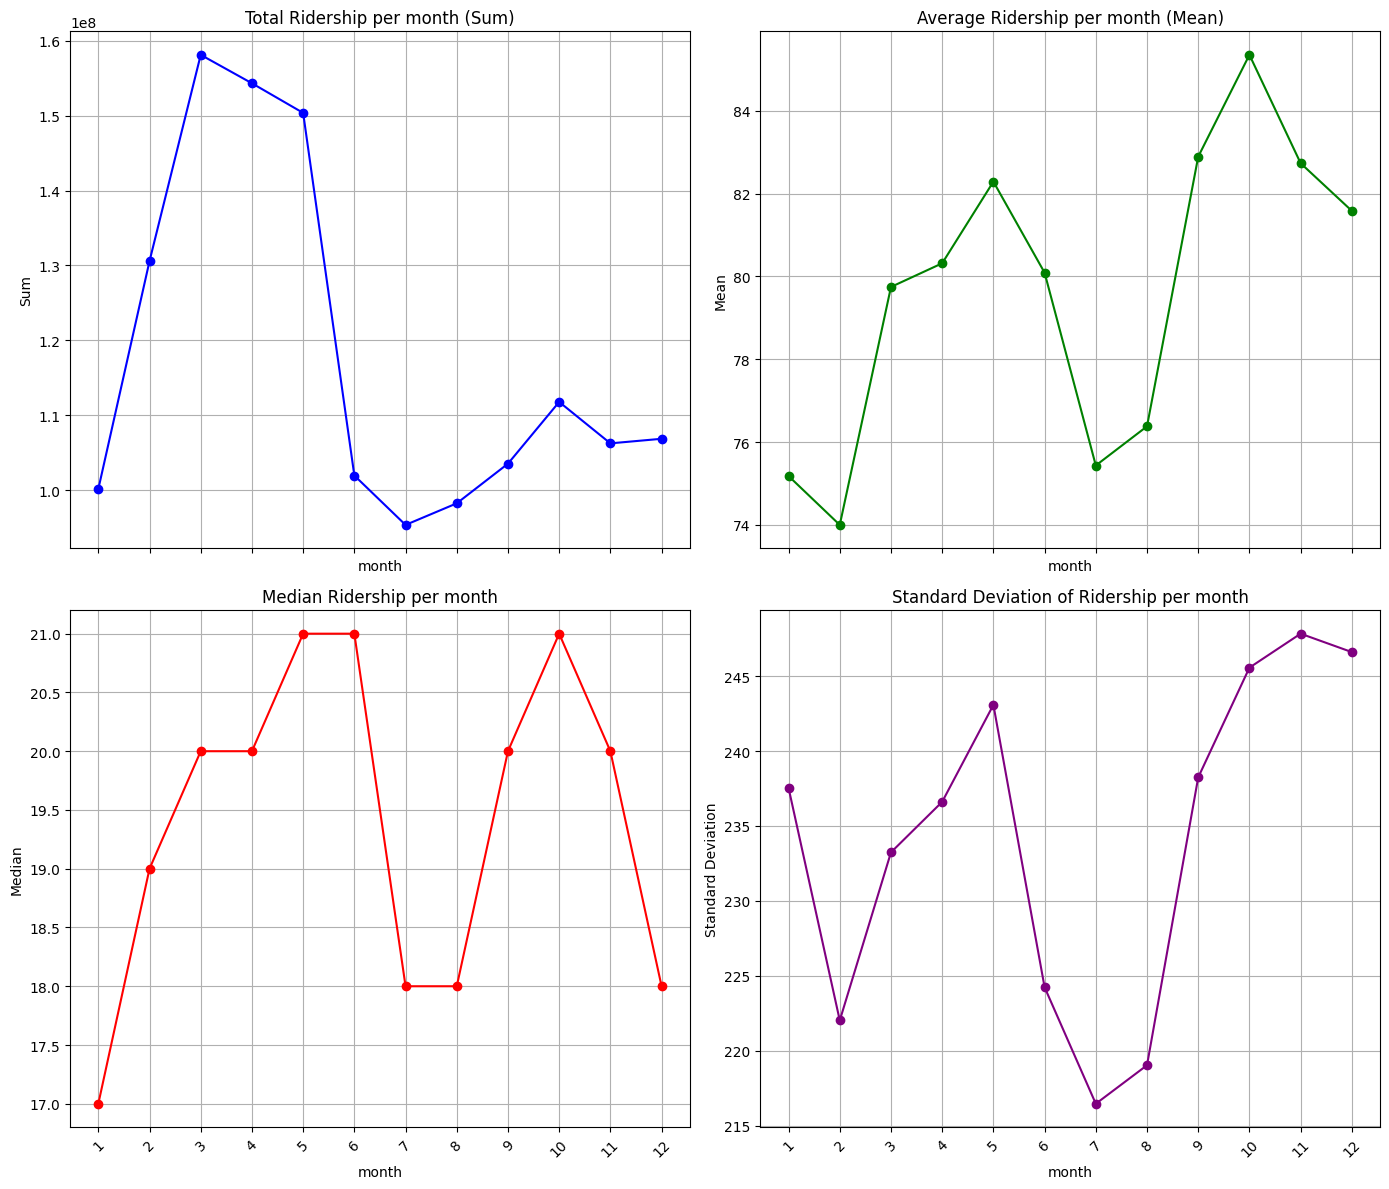

In [105]:
plot_stats_per_period('month')

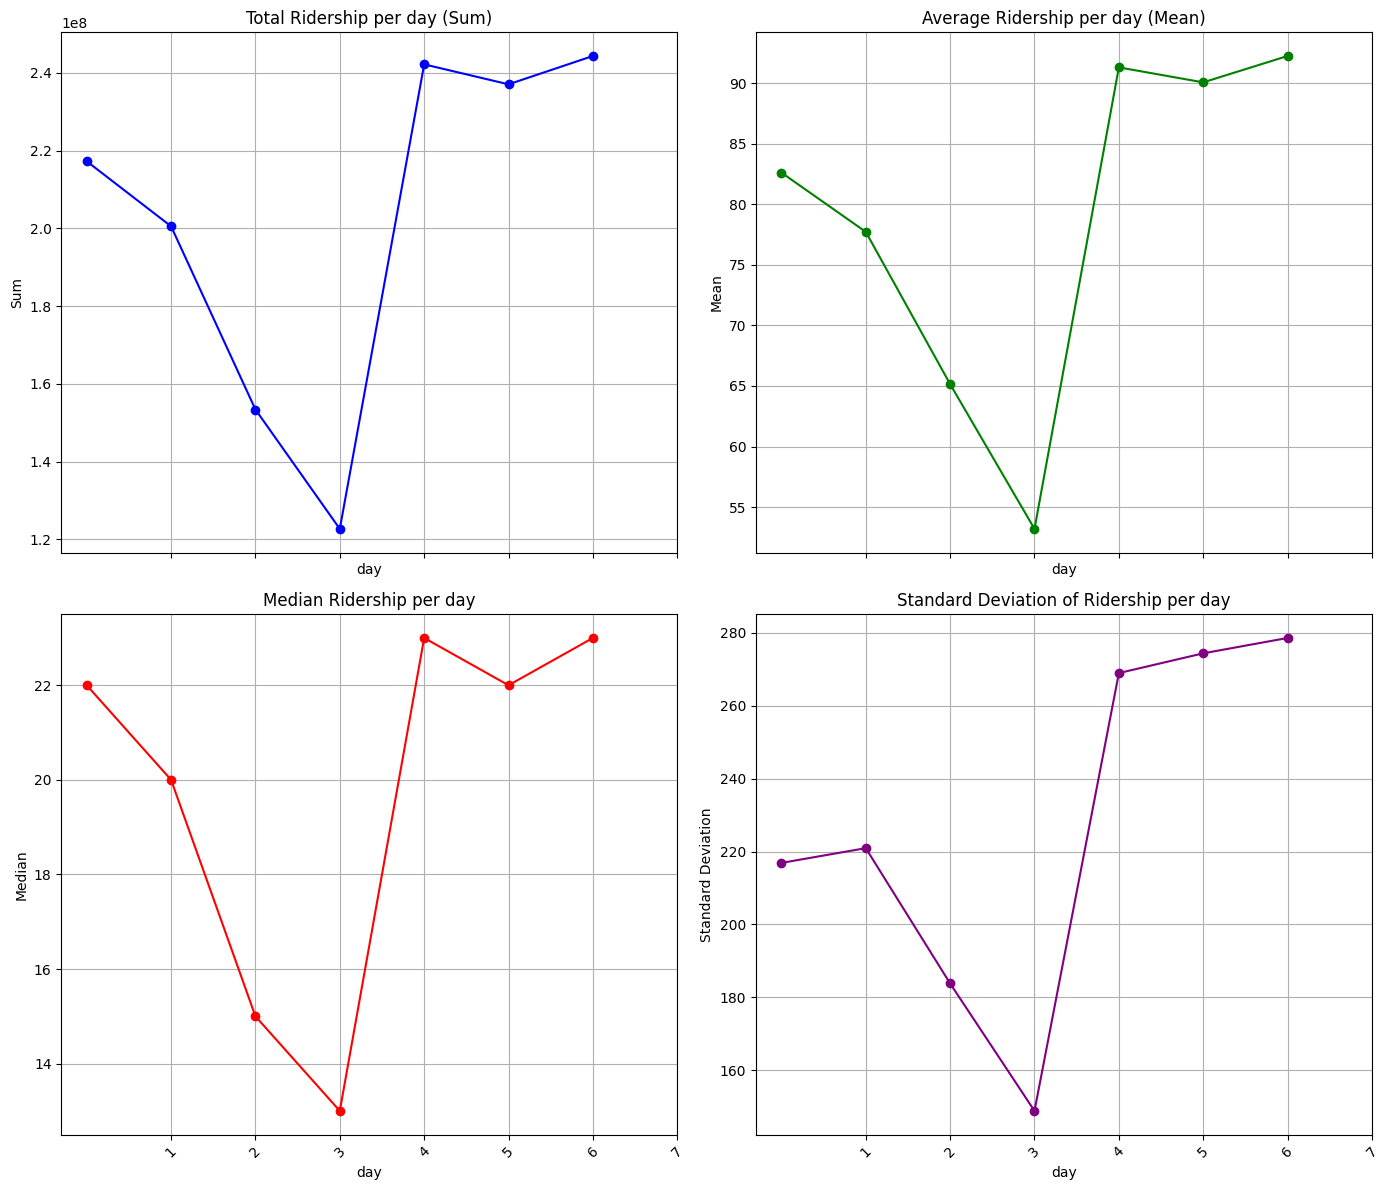

In [106]:
plot_stats_per_period('day')

In [113]:
ddf[['day']] = ddf[['day']].astype('category')
# Create a mapping dictionary
days_mapping = dict(enumerate(ddf['day'].cat.categories))

# Display the mapping
days_mapping

{0: 'Friday',
 1: 'Monday',
 2: 'Saturday',
 3: 'Sunday',
 4: 'Thursday',
 5: 'Tuesday',
 6: 'Wednesday'}

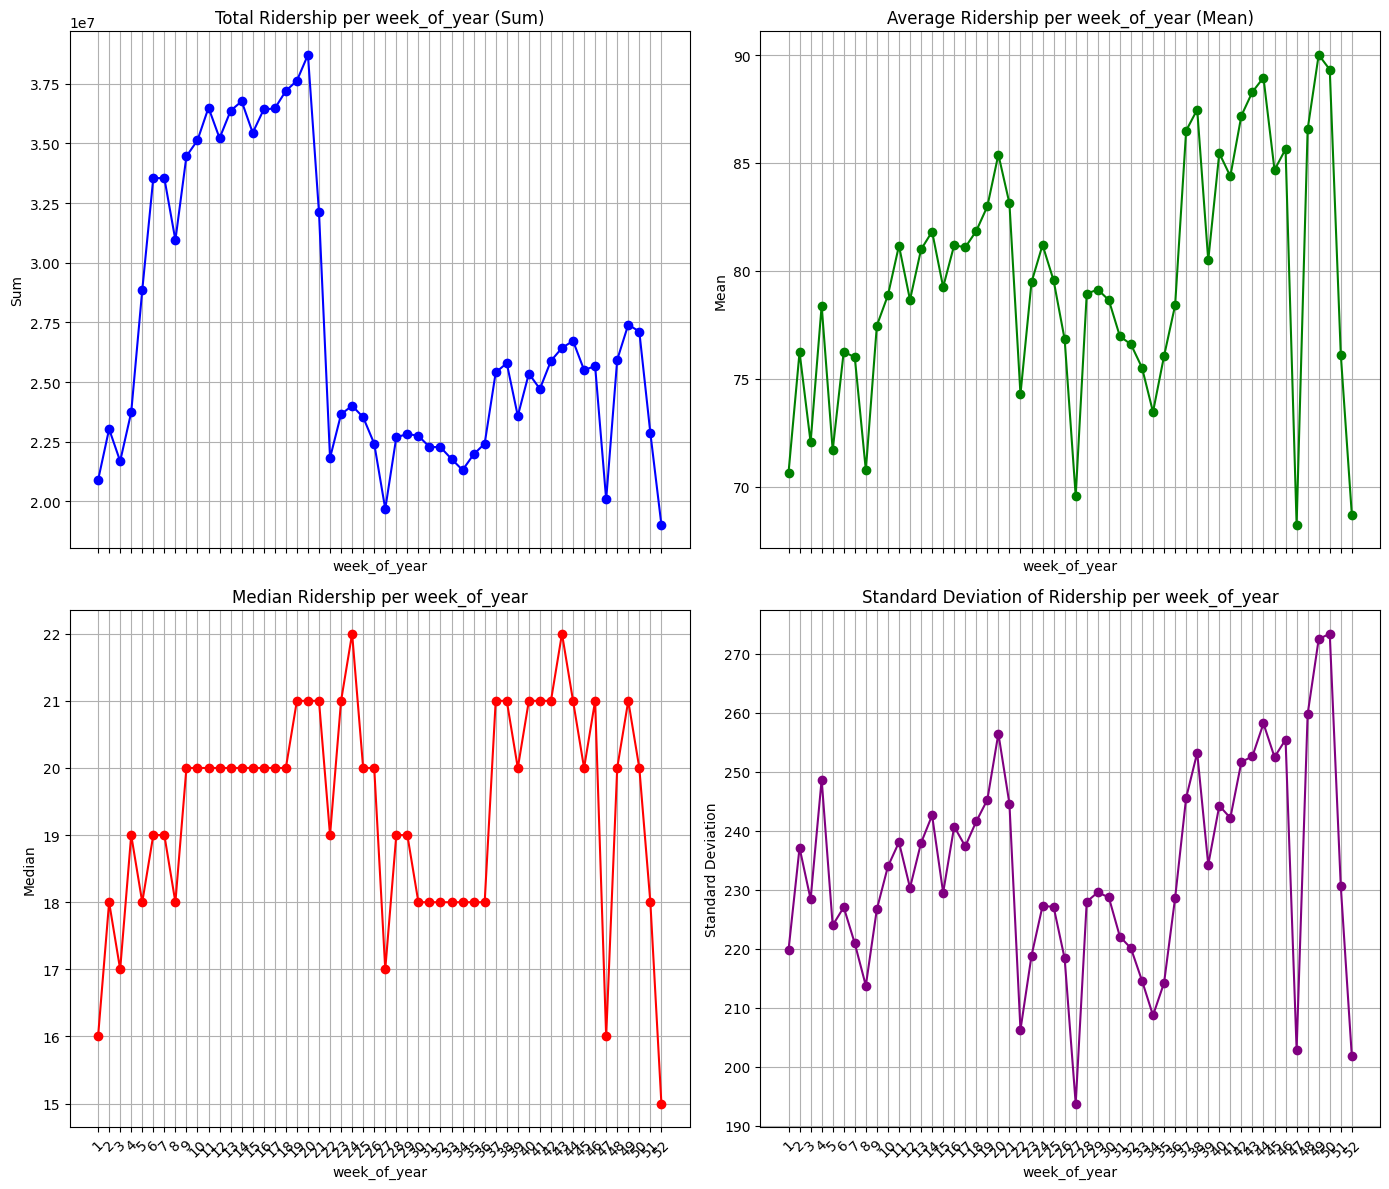

In [107]:
plot_stats_per_period('week_of_year')